https://skojaku.github.io/applied-soft-comp/m01-word-embedding/bias-in-embedding.html

In [1]:
import numpy as np
from gensim.downloader import load

# Load word vectors
vectors = load('word2vec-google-news-300')

def compute_bias(word, microframe):
    word_vector = vectors[word]
    return np.dot(word_vector, microframe) / (
        np.linalg.norm(word_vector) * np.linalg.norm(microframe)
    )

def analyze(word, pos_word, neg_word):
    if word not in vectors:
        return 0.0
    microframe = vectors[pos_word] - vectors[neg_word]
    bias = compute_bias(word, microframe)
    return bias

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [2]:
# Occupations from the paper
she_occupations = [
    "homemaker", "nurse", "receptionist", "librarian", "socialite",
    "hairdresser", "nanny", "bookkeeper", "stylist", "housekeeper",
]

he_occupations = [
    "maestro", "skipper", "protege", "philosopher", "captain",
    "architect", "financier", "warrior", "broadcaster", "magician",
    "boss"
]

In [3]:
# Analyze gender bias in occupations
print("Gender Bias in Occupations (she-he axis):")
print("\nShe-associated occupations:")
for occupation in she_occupations:
    bias = analyze(occupation, "she", "he")
    print(f"{occupation}: {bias:.3f}")

print("\nHe-associated occupations:")
for occupation in he_occupations:
    bias = analyze(occupation, "she", "he")
    print(f"{occupation}: {bias:.3f}")

Gender Bias in Occupations (she-he axis):

She-associated occupations:
homemaker: 0.360
nurse: 0.333
receptionist: 0.329
librarian: 0.300
socialite: 0.310
hairdresser: 0.307
nanny: 0.287
bookkeeper: 0.264
stylist: 0.252
housekeeper: 0.260

He-associated occupations:
maestro: -0.203
skipper: -0.177
protege: -0.148
philosopher: -0.155
captain: -0.130
architect: -0.151
financier: -0.145
warrior: -0.120
broadcaster: -0.124
magician: -0.110
boss: -0.090


In [4]:
# Stereotype analogies from the paper
stereotype_pairs = [
    ("sewing", "carpentry"),
    ("nurse", "surgeon"),
    ("softball", "baseball"),
    ("cosmetics", "pharmaceuticals"),
    ("vocalist", "guitarist")
]

print("\nAnalyzing Gender Stereotype Pairs:")
for word1, word2 in stereotype_pairs:
    bias1 = analyze(word1, "she", "he")
    bias2 = analyze(word2, "she", "he")
    print(f"\n{word1} vs {word2}")
    print(f"{word1}: {bias1:.3f}")
    print(f"{word2}: {bias2:.3f}")


Analyzing Gender Stereotype Pairs:

sewing vs carpentry
sewing: 0.302
carpentry: -0.028

nurse vs surgeon
nurse: 0.333
surgeon: -0.048

softball vs baseball
softball: 0.260
baseball: -0.066

cosmetics vs pharmaceuticals
cosmetics: 0.331
pharmaceuticals: -0.011

vocalist vs guitarist
vocalist: 0.140
guitarist: -0.041


In [5]:
# Words associated with softball-football axis
softball_associations = [
    "pitcher", "bookkeeper", "receptionist",
    "nurse", "waitress"
]

football_associations = [
    "footballer", "businessman", "pundit",
    "maestro", "cleric"
]

# Analyze bias along both gender and sports axes
import matplotlib.pyplot as plt

# Calculate biases for all words
gender_biases = []
sports_biases = []
words = softball_associations + football_associations

for word in words:
    gender_bias = analyze(word, "she", "he")
    sports_bias = analyze(word, "softball", "football")
    gender_biases.append(gender_bias)
    sports_biases.append(sports_bias)

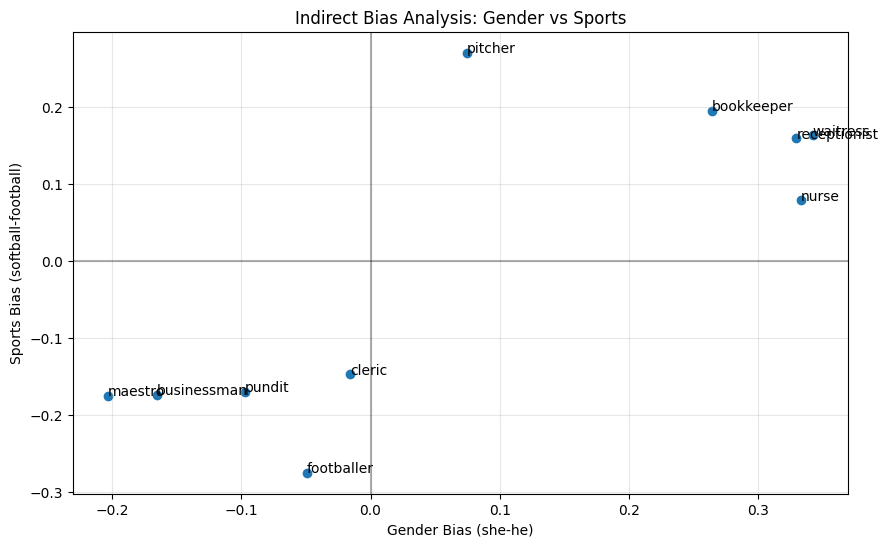


Indirect Bias Analysis (Numerical Results):

pitcher:
Gender bias: 0.075
Sports bias: 0.270

bookkeeper:
Gender bias: 0.264
Sports bias: 0.195

receptionist:
Gender bias: 0.329
Sports bias: 0.159

nurse:
Gender bias: 0.333
Sports bias: 0.079

waitress:
Gender bias: 0.342
Sports bias: 0.163

footballer:
Gender bias: -0.049
Sports bias: -0.275

businessman:
Gender bias: -0.166
Sports bias: -0.174

pundit:
Gender bias: -0.097
Sports bias: -0.170

maestro:
Gender bias: -0.203
Sports bias: -0.175

cleric:
Gender bias: -0.016
Sports bias: -0.147


In [6]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(gender_biases, sports_biases)

# Add labels for each point
for i, word in enumerate(words):
    plt.annotate(word, (gender_biases[i], sports_biases[i]))

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.xlabel('Gender Bias (she-he)')
plt.ylabel('Sports Bias (softball-football)')
plt.title('Indirect Bias Analysis: Gender vs Sports')

# Add grid for better readability
plt.grid(True, alpha=0.3)
plt.show()

# Print numerical results
print("\nIndirect Bias Analysis (Numerical Results):")
for i, word in enumerate(words):
    print(f"\n{word}:")
    print(f"Gender bias: {gender_biases[i]:.3f}")
    print(f"Sports bias: {sports_biases[i]:.3f}")